In [1]:
import pandas_plink as pp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score
import random
import os
import tarfile
import gzip
from tools import extract_data

In [ ]:
genotype_compressed = '../data/LDREF.tar.bz2'
phenotype_data = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz'

# alleles = .bim (snp. came from vcf file (txt file))
# samples = .fam (family id)
# genotypes = .bed (genotypes). Rows and columns defined by alleles and samples
(alleles, samples, genotypes) = pp.read_plink("../data/LDREF/1000G.EUR.*",
                             verbose=False)
genotypes = pd.DataFrame(genotypes.compute())
P = pd.read_csv(phenotype_data, sep='\t', compression='gzip')

In [21]:
chr_to_explore = '19'
gene_to_explore = 'ENSG00000083844.5'

#target_chr_data = P[P['Chr'] == chr_to_explore]
#target_chr_data

In [22]:
def cis_eQTL_analysis(chr, gene, alleles, samples, genotypes, phenotypes, window=500000, mult_gene=False):
    target_gene_data = phenotypes[phenotypes['Gene_Symbol']==gene].reset_index(drop=True)
    target_gene_data['start'] = target_gene_data['Coord'] - window
    target_gene_data['end'] = target_gene_data['Coord'] + window
    target_gene_alleles = alleles[(alleles['chrom'] == chr) & (alleles['pos'] <= target_gene_data['end'].values[0]) & (alleles['pos'] >= target_gene_data['start'].values[0])]
    snp_ids = dict(zip(target_gene_alleles.index, target_gene_alleles['snp'].values))
    target_gene_genotypes = genotypes.iloc[target_gene_alleles.index].T.rename(columns=snp_ids)
    sample_ids = [t for t in target_gene_data.columns if t not in ['TargetID', 'Gene_Symbol', 'Chr', 'start', 'end']]
    full_target_gene_data = target_gene_genotypes.merge(samples, how='left', left_index=True, right_index=True).merge(target_gene_data[sample_ids].T.rename(columns=snp_ids), how='left', left_on='fid', right_index=True).rename(columns={0: 'expression'}).drop(columns=['iid', 'father', 'mother', 'gender', 'trait', 'i'])
    full_target_gene_data = full_target_gene_data[~full_target_gene_data['expression'].isna()]
    y = full_target_gene_data['expression'].to_numpy()
    all_snps = full_target_gene_data.columns[:-2]
    snp_regs = {}
    snp_data = {}
    for snp in all_snps:
        temp_x = full_target_gene_data[snp].values 
        temp_x = sm.add_constant(temp_x, has_constant='add')
       
        model = sm.OLS(y,temp_x)
        results = model.fit()
        snp_regs[snp] = results
        snp_data[snp] = {
            'p_val': results.pvalues[1],    
            'beta': results.params[1],
            'se': results.tvalues[1],
        } 

    target_gene_linreg = pd.DataFrame.from_dict(snp_data, orient='index').reset_index().rename(columns={'index': 'snp'})
    target_gene_linreg['gene'] = gene
    target_gene_linreg['gene_pos'] = target_gene_data['Coord'].values[0]
    target_gene_linreg['n'] = samples.shape[0]
    
    if mult_gene:
        return target_gene_linreg
    return target_gene_linreg.merge(alleles[['snp', 'chrom', 'pos', 'a0', 'a1', 'i']], how='left', on='snp')



In [23]:
#cis_eQTL_analysis(chr_to_explore, gene_to_explore, alleles, samples, genotypes, P)

In [24]:
def chr_analysis(chr, alleles, samples, genotypes, phenotypes, window=500000):
    target_chr_data = P[P['Chr']==chr]
    all_genes = target_chr_data['Gene_Symbol'].unique()
    all_analyses=[]
    print(f'Starting cis-eQTL analyses for chromosome {chr}')

    gene_counter = 0
    total_genes = len(all_genes)
    for g in all_genes:
        if gene_counter%100==0:
            print(f'{gene_counter}/{total_genes} analyses completed')
        temp_df = cis_eQTL_analysis(chr, g, alleles, samples, genotypes, phenotypes, window, True)
        all_analyses.append(temp_df.copy())
        gene_counter += 1
    print(f'Compiling results')
    return pd.concat(all_analyses).merge(alleles[['snp', 'chrom', 'pos', 'a0', 'a1', 'i']], how='left', on='snp')

    #return pd.concat(all_analyses).merge(pd.merge(alleles[['snp', 'chrom', 'pos', 'a0', 'a1', 'i']], effect_allele_freq, how='left', on='snp'), how='left', on='snp')


In [25]:
#temp_testing = chr_analysis('4', alleles, samples, genotypes, P)


In [26]:
# CLUMPING COMMAND WITH PLINK
"""
plink 
    --bfile 1000G_eur_train_${gene} 
    --clump-p1 $p_val 
    --clump-r2 $r2 
    --clump-kb 250 
    --clump ${eqtl_sumstats_file} 
    --clump-snp-field SNP 
    --clump-field P 
    --out 1000G_eur_train_${gene}
"""

def clump(df, p1, r2):
    return df[(df['p_val'] <= p1) & (df['r_sq'] <= r2)]

In [ ]:
#!plink2 –bfile 1000G.EUR.15 –extract bed1 $my_coord –out 1000G.EUR.15.GeneX –make-bed

PLINK v2.0.0-a.5.16 64-bit (9 Oct 2024)            cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise, --ld,
--sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --clump, --score, --variant-score, --genotyping-rate, --pgen-info,
--validate, and --zst-decompress.

"plink2 --help | more" describes all functions.


In [27]:
# Sampling population
known_expressions = P[P['TargetID']==gene_to_explore]
known_fids = list(known_expressions.columns[4:].values)
random.shuffle(known_fids)
known_expressions

TargetID        Gene_Symbol Chr     Coord   HG00096   HG00097  \
10011  ENSG00000083844.5  ENSG00000083844.5  19  57702868  3.080794  2.754739   

        HG00099   HG00100   HG00101   HG00102  ...   NA20810   NA20811  \
10011  1.323061  2.141503  2.286706  4.298008  ...  2.212544  1.761838   

        NA20812   NA20813   NA20814   NA20815   NA20816   NA20819   NA20826  \
10011  2.170416  2.058268  2.039293  2.157605  2.358081  2.502629  2.211326   

        NA20828  
10011  2.489855  

[1 rows x 466 columns]

In [28]:
known_expressions['HG00102']

10011    4.298008
Name: HG00102, dtype: float64

In [29]:
num_analysis = int(0.8 * len(known_fids))
num_valid = (len(known_fids) - num_analysis) // 2
num_test = len(known_fids) - num_valid - num_analysis
analysis_fids = known_fids[:num_analysis]
valid_fids = known_fids[num_analysis:num_analysis+num_valid]
test_fids = known_fids[num_analysis+num_valid:]
print(num_analysis, num_valid, num_test)


369 46 47


In [30]:
analysis_samples = samples[samples['fid'].isin(analysis_fids)]
analysis_genotypes = genotypes[analysis_samples['i'].values]
analysis_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(analysis_fids)]

valid_samples = samples[samples['fid'].isin(valid_fids)]
valid_genotypes = genotypes[valid_samples['i'].values]
valid_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(valid_fids)]


test_samples = samples[samples['fid'].isin(test_fids)]
test_genotypes = genotypes[test_samples['i'].values]
test_phenotypes = P[P['TargetID']==gene_to_explore][['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(test_fids)]



In [31]:
target_gene_analysis = cis_eQTL_analysis(chr_to_explore, gene_to_explore, \
                            alleles, analysis_samples, analysis_genotypes, \
                                analysis_phenotypes)
target_gene_analysis


snp     p_val      beta        se               gene  gene_pos  \
0    rs10420802  0.153850  0.075989  1.430079  ENSG00000083844.5  57702868   
1    rs11084462  0.368714 -0.044198 -0.900392  ENSG00000083844.5  57702868   
2     rs8110561  0.644109  0.015692  0.462481  ENSG00000083844.5  57702868   
3     rs7256661  0.479315  0.023827  0.708390  ENSG00000083844.5  57702868   
4     rs7259910  0.955491  0.003019  0.055865  ENSG00000083844.5  57702868   
..          ...       ...       ...       ...                ...       ...   
505    rs752150  0.248249  0.051123  1.157112  ENSG00000083844.5  57702868   
506   rs3746208  0.345538 -0.032785 -0.944933  ENSG00000083844.5  57702868   
507  rs12608564  0.478396  0.030660  0.709872  ENSG00000083844.5  57702868   
508  rs12981782  0.740559  0.011307  0.331453  ENSG00000083844.5  57702868   
509   rs9304798  0.740559  0.011307  0.331453  ENSG00000083844.5  57702868   

       n chrom       pos a0 a1       i  
0    272    19  57202924  C  T  528962  
1    272    19  57203105  A  G  528963  
2    272    19  57203735  T  C  528964  
3    272    19  57210786  A  C  528965  
4    272    19  57210943  A  C  528966  
..   ...   ...       ... .. ..     ...  
505  272    19  58196207  A  G  529467  
506  272    19  58200099  T  C  529468  
507  272    19  58200497  A  G  529469  
508  272    19  58201360  T  C  529470  
509  272    19  58202809  T  C  529471  

[510 rows x 12 columns]

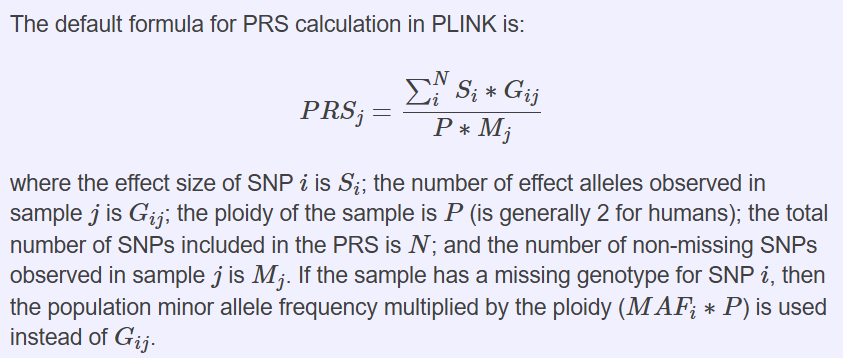

In [34]:
#Y_i = sum_j(X_ij * Beta_j) + error_i
#X^_ij (testing)B^_j = Y^_i=PRS
p_vals = [1, 0.05, 0.01, 0.001, 0.00001]
def prs_gene_pipeline(analysis_df, samples, genotypes, p_val):
    analysis_df = analysis_df[analysis_df['p_val'] <= p_val]
    prs = {}
    for iid in samples['i']:
        numerator = 0
        denominator = 2 * analysis_df.shape[0]
        for snp in analysis_df['i']:
            temp_snp = analysis_df[analysis_df['i']==snp]
            temp_beta = temp_snp['beta'].values[0]
            temp_ea_count = genotypes[iid].iloc[snp]
            numerator += temp_beta * temp_ea_count
        temp_fid = samples[samples['i']==iid]['fid'].values[0]
        
        prs[temp_fid] = numerator / (denominator + 1e-10)
    return prs

In [40]:
valid_expressions = P[P['TargetID']==gene_to_explore][valid_samples['fid']].reset_index(drop=True).T.rename(columns={0:'expression'})
for p in p_vals:
    valid_prs = prs_gene_pipeline(target_gene_analysis, valid_samples, valid_genotypes, p)
    valid_prs_df = pd.DataFrame.from_dict(valid_prs, orient='index').rename(columns={0: f'predicted_{p}'})
    valid_expressions = valid_expressions.merge(valid_prs_df, how='outer', left_index=True, right_index=True)

valid_expressions.head()

expression  predicted_1  predicted_0.05  predicted_0.01  \
HG00102    4.298008     0.004188        0.020103        0.046199   
HG00105    2.409477     0.003038        0.017225        0.046199   
HG00128    2.081891     0.000460        0.010076        0.028462   
HG00133    2.329944     0.002464        0.016384        0.056922   
HG00141    2.186208     0.002123        0.005662        0.033040   

         predicted_0.001  predicted_1e-05  
HG00102              0.0              0.0  
HG00105              0.0              0.0  
HG00128              0.0              0.0  
HG00133              0.0              0.0  
HG00141              0.0              0.0

In [37]:
def r_squared(df, x1, x2):
    temp_r = df[x1].corr(df[x2])
    if np.isnan(temp_r):
        temp_r = 0
    return temp_r ** 2


In [38]:
to_compare = ['predicted_1', 'predicted_0.05', 'predicted_0.01', 'predicted_0.001', 'predicted_1e-05']
valid_r_sq = {}
for c in to_compare:
    temp_p_val = c.split('_')[-1]
    valid_r_sq[temp_p_val] = r_squared(valid_expressions, 'expression', c)

valid_r_sq

c:\Users\garve\anaconda3\envs\dsc\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\garve\anaconda3\envs\dsc\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'1': 0.004299423786926742,
 '0.05': 0.006310657392035283,
 '0.01': 0.03124846406071088,
 '0.001': 0,
 '1e-05': 0}

In [39]:
test_expressions = P[P['TargetID']==gene_to_explore][test_samples['fid']].reset_index(drop=True).T.rename(columns={0:'expression'})

test_prs = prs_gene_pipeline(target_gene_analysis, test_samples, test_genotypes, 1)
test_prs_df = pd.DataFrame.from_dict(test_prs, orient='index').rename(columns={0: f'predicted'})

test_expressions = test_expressions.merge(test_prs_df, how='outer', left_index=True, right_index=True)

r_squared(test_expressions,'expression', 'predicted')


0.08718363097606541